https://habr.com/ru/company/ods/blog/327242/

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
#    iplot(fig, show_link=False)

dataset = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])
plotly_df(dataset, title = "Online users")

In [4]:
dataset.head()

,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517
2017-01-01 03:00:00,44476
2017-01-01 04:00:00,46234


# Скользящее среднее

In [5]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(dataset.Users, 24)

29858.333333333332

In [6]:
def plotMovingAverage(series, n, with_std=False):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    if with_std:
        # При желании, можно строить и доверительные интервалы для сглаженных значений
        rolling_std =  series.rolling(window=n).std()
        upper_bond = rolling_mean+1.96*rolling_std
        lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    if with_std:
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
    plt.plot(dataset[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

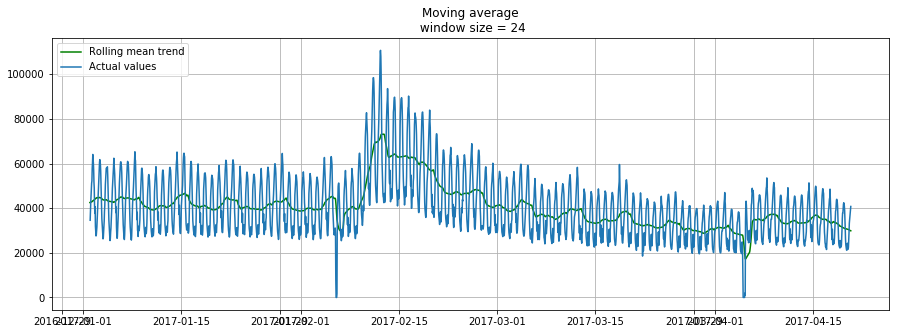

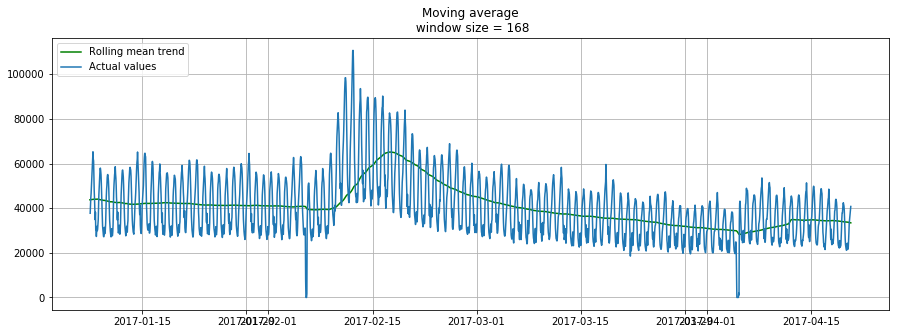

In [7]:
plotMovingAverage(dataset, 24) # сглаживаем по дням
plotMovingAverage(dataset, 24*7) # сглаживаем по неделям

# Взвешенное среднее

In [8]:
def weighted_average(series, weights):
    assert np.sum(weights) == 1.0
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weighted_average(dataset.Users, [0.6, 0.2, 0.1, 0.07, 0.03])

35967.55

# Экспоненциальное сглаживание

In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

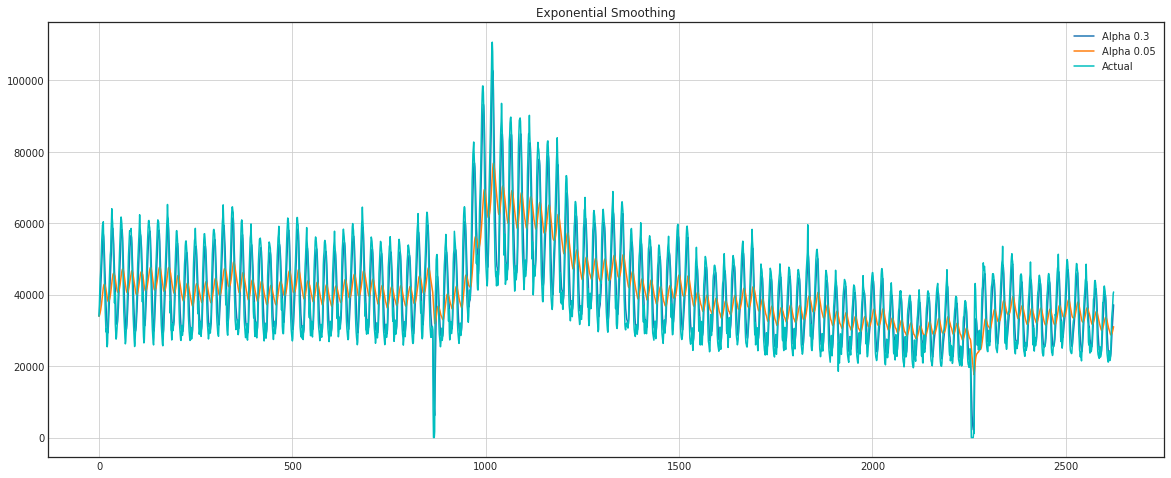

In [10]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset.Users, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset.Users.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

# Двойное экспоненциальное сглаживание

In [11]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

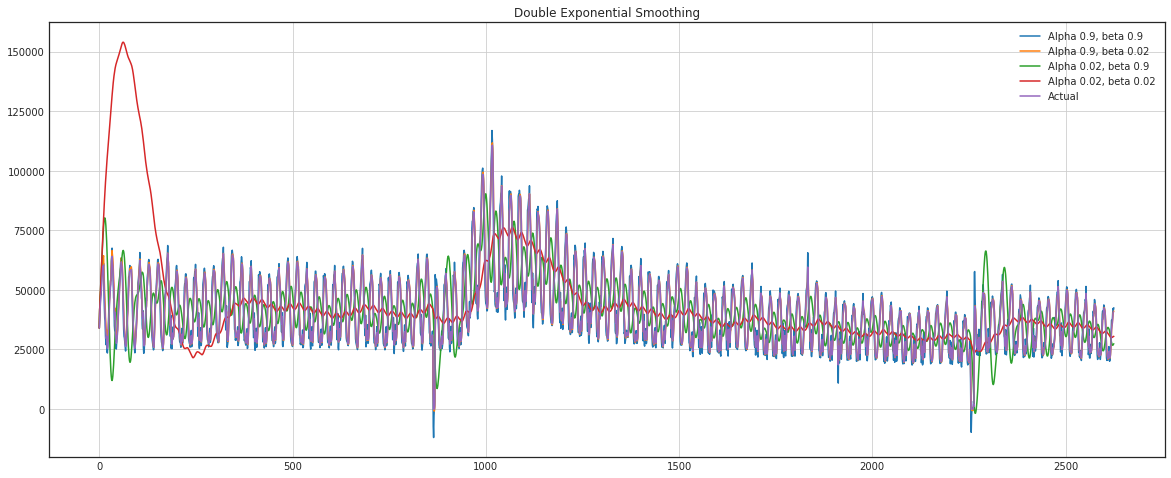

In [12]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Users, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

# Тройное экспоненциальное сглаживание (модель Хольта-Винтерса)

In [13]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

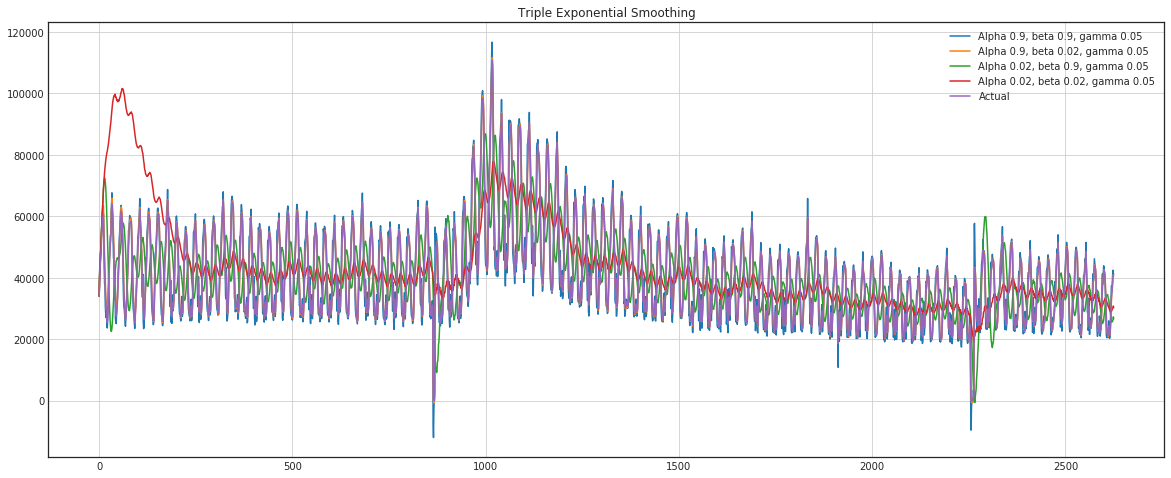

In [14]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
                for gamma in [0.05]:
                    HW = HoltWinters(dataset.Users, 3, alpha, beta, gamma, 1)
                    HW.triple_exponential_smoothing()
                    plt.plot(HW.result, label="Alpha {}, beta {}, gamma {}".format(alpha, beta, gamma))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Triple Exponential Smoothing")
    plt.grid(True)

# Кросс-валидация

In [15]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x, data):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [16]:

data = dataset.Users[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, args=(data), x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.006634267064344168 0.0 0.0467652042896729


In [17]:
data = dataset.Users
model = HoltWinters(
    data[:-128],
    slen = 24*7,
    alpha = alpha_final,
    beta = beta_final,
    gamma = gamma_final,
    n_preds = 128,
    scaling_factor = 2.56
)
model.triple_exponential_smoothing()

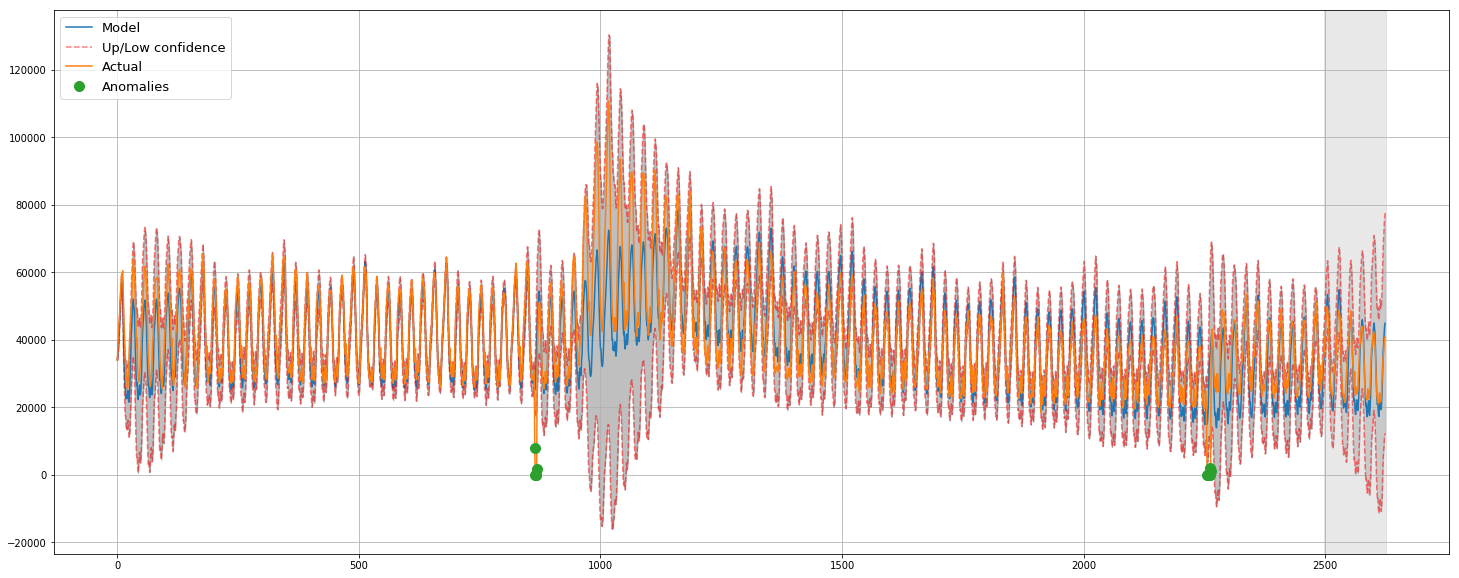

In [18]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values < model.LowerBond] = data.values[data.values < model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()

# Эконометрический подход

## Стационарные ряды

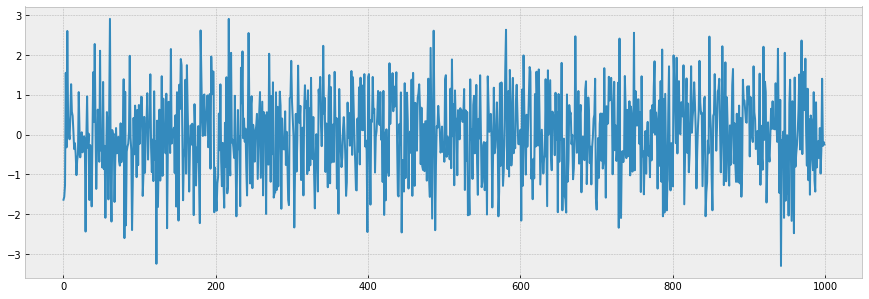

In [19]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

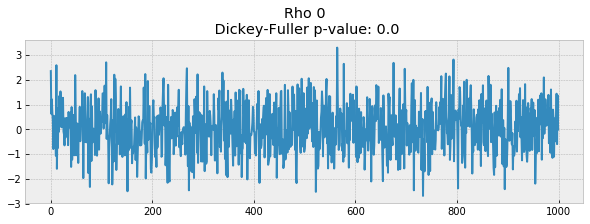

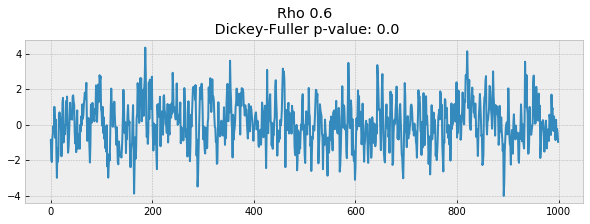

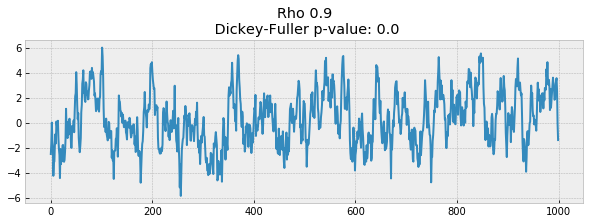

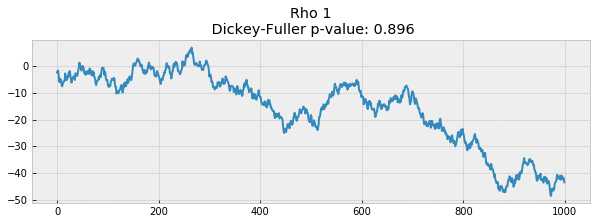

In [20]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

# Избавляемся от нестационарности

## автокорреляция - http://www.prognoz.ru/blog/platform/vremennye-ryady-i-poisk-igolki-v-stoge-sena/

## частная автокорреляция - https://www.youtube.com/watch?v=ch4BZS_QC9s

Критерий Дики-Фуллера: p=0.190189


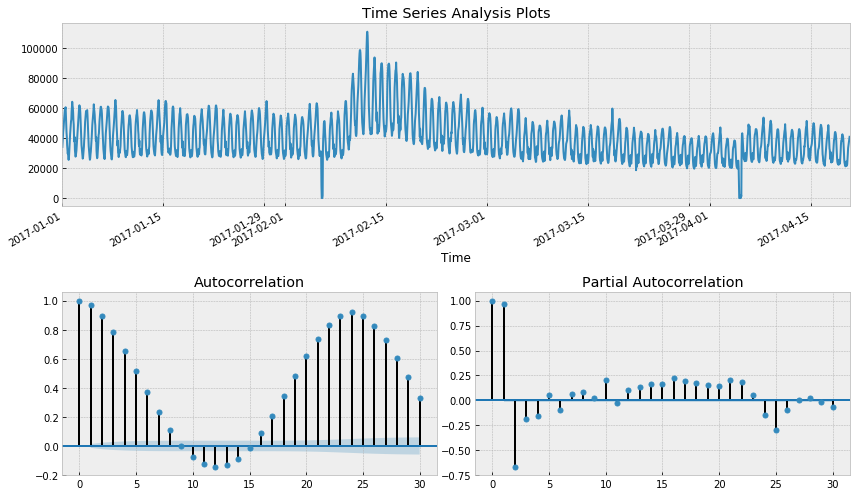

In [21]:
import matplotlib
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(dataset.Users, lags=30)

Критерий Дики-Фуллера: p=0.079760
Оптимальный параметр преобразования Бокса-Кокса: 0.587270


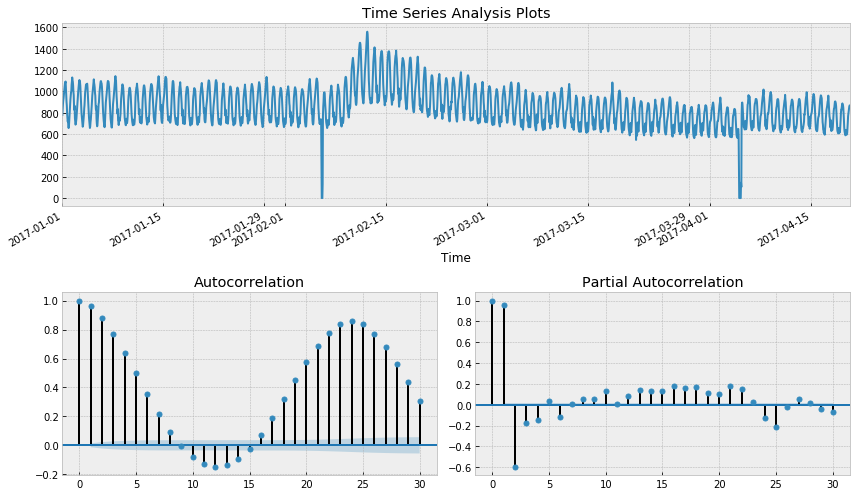

In [22]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = dataset.copy()
data['Users_box'], lmbda = scs.boxcox(data.Users+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.Users_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.002571


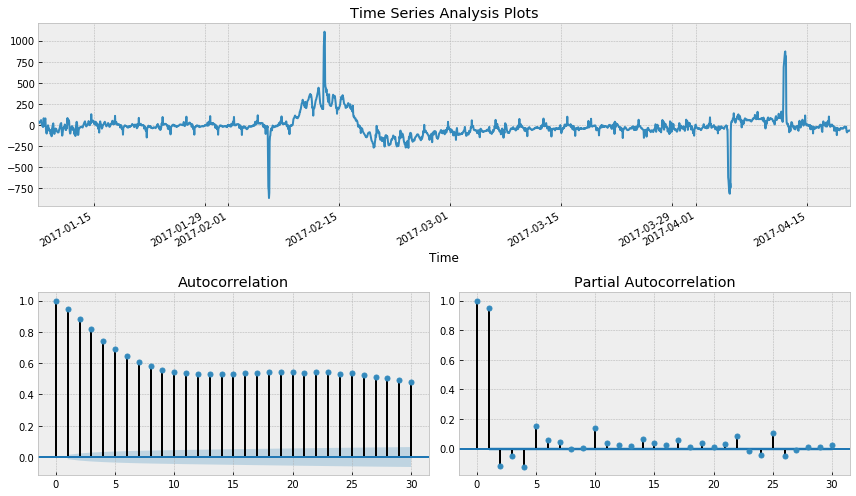

In [23]:
data['Users_box_season'] = data.Users_box - data.Users_box.shift(24*7)
tsplot(data.Users_box_season[24*7:], lags=30)

Критерий Дики-Фуллера: p=0.000000


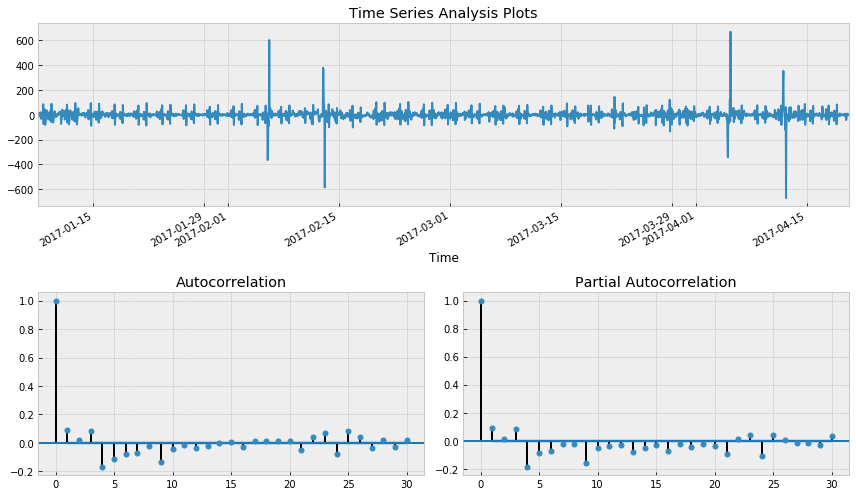

In [24]:
data['Users_box_season_diff'] = data.Users_box_season - data.Users_box_season.shift(1)
tsplot(data.Users_box_season_diff[24*7+1:], lags=30)

# SARIMA

подробный туториал по SARIMAX в Python https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

order (iterable or iterable of iterables, optional) – The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).

seasonal_order (iterable, optional) – The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. s is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect.

In [25]:
ps = range(1,3) #range(0, 5)
d=1
qs = range(1,3) #range(0, 4)
Ps = range(1,3) #range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [ ]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(data.Users_box, order=(param[0], d, param[1]), 
                                          seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  0%|          | 0/8 [00:00<?, ?it/s]/Users/akhtyamovpavel/Environments/ResearchVenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [27]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.Users_box, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=True)
print(best_model.summary())  

                                 Statespace Model Results                                 
Dep. Variable:                          Users_box   No. Observations:                 2625
Model:             SARIMAX(4, 1, 3)x(4, 1, 1, 24)   Log Likelihood              -12551.548
Date:                            Sat, 18 May 2019   AIC                          25129.096
Time:                                    08:39:50   BIC                          25205.318
Sample:                                         0   HQIC                         25156.713
                                           - 2625                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1734      0.312      3.765      0.000       0.562       1.784
ar.L2         -0.4848      0.466   

In [30]:
best_model = sm.tsa.statespace.SARIMAX(data.Users_box, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=True)

## Строим прогноз

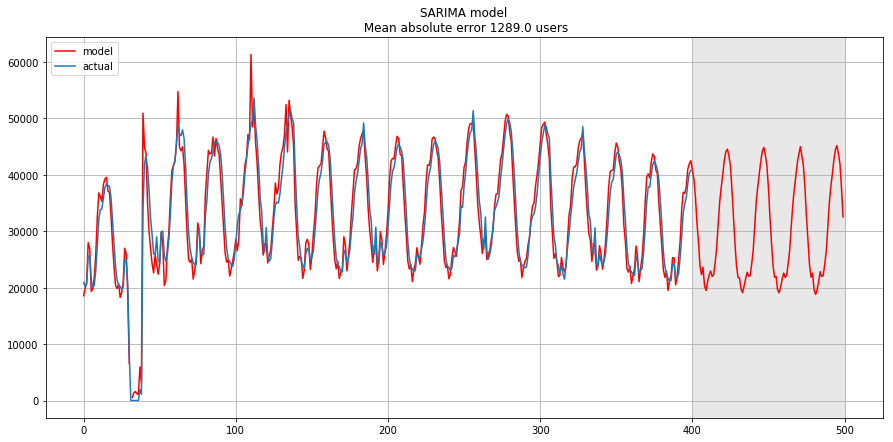

In [31]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+100), lmbda)
forecast = data.arima_model.append(forecast).values[-500:]
actual = data.Users.values[-400:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().Users, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

# Машинное обучение. Семинар 2.

## Извлечение признаков

In [32]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [33]:
data = pd.DataFrame(dataset.copy())
data.columns = ["y"]

#data.index = data.index.to_datetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,y,hour,weekday,is_weekend
Time,,,,
2017-01-01 00:00:00,34002,0,6,1
2017-01-01 01:00:00,37947,1,6,1
2017-01-01 02:00:00,41517,2,6,1
2017-01-01 03:00:00,44476,3,6,1
2017-01-01 04:00:00,46234,4,6,1


In [34]:
code_mean(data, 'weekday', "y")

{0: 38730.143229166664,
 1: 38632.828125,
 2: 38128.518229166664,
 3: 39519.035135135135,
 4: 41505.15277777778,
 5: 43717.708333333336,
 6: 43392.14360313316}

In [35]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

#    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5, 6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['Lag1'] = data.y.shift(1)
    
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))
    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

## Линейная регрессия

In [36]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(dataset.Users, test_size=0.3, lag_start=1, lag_end=48)
X_train.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,is_weekend,Lag1,weekday_average,hour_average
0,29917.0,28062.0,27558.0,29656.0,31857.0,40607.0,37652.0,41202.0,48996.0,51527.0,...,48842.0,46234.0,44476.0,41517.0,37947.0,34002.0,0,29917.0,41842.412879,33386.789474
1,31512.0,29917.0,28062.0,27558.0,29656.0,31857.0,40607.0,37652.0,41202.0,48996.0,...,52245.0,48842.0,46234.0,44476.0,41517.0,37947.0,0,31512.0,42007.075758,34056.272727
2,34801.0,31512.0,29917.0,28062.0,27558.0,29656.0,31857.0,40607.0,37652.0,41202.0,...,55245.0,52245.0,48842.0,46234.0,44476.0,41517.0,0,34801.0,42007.075758,36313.363636
3,38149.0,34801.0,31512.0,29917.0,28062.0,27558.0,29656.0,31857.0,40607.0,37652.0,...,57725.0,55245.0,52245.0,48842.0,46234.0,44476.0,0,38149.0,42007.075758,39022.460526
4,41146.0,38149.0,34801.0,31512.0,29917.0,28062.0,27558.0,29656.0,31857.0,40607.0,...,59534.0,57725.0,55245.0,52245.0,48842.0,46234.0,0,41146.0,42007.075758,44208.467532


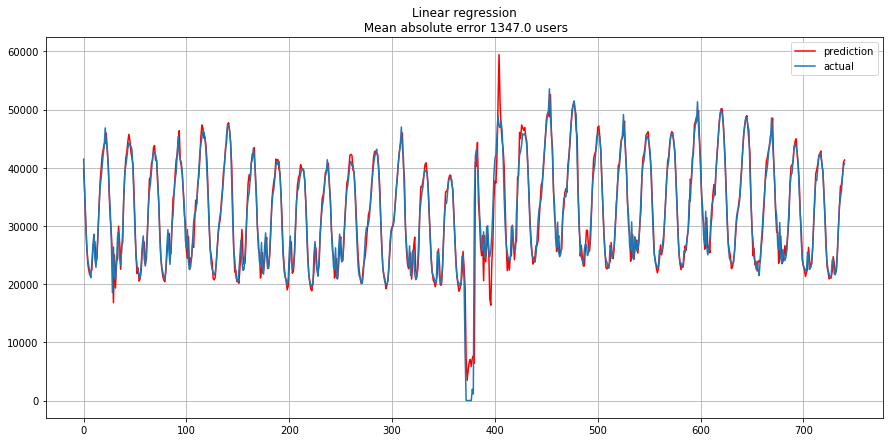

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [38]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds - 1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i - 2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [39]:
%%time
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (1838, 51)
Size of each fold: 367

Splitting the first 2 chunks at 1/2
Size of train + test: (734, 51)

Splitting the first 3 chunks at 2/3
Size of train + test: (1101, 51)

Splitting the first 4 chunks at 3/4
Size of train + test: (1468, 51)

Splitting the first 5 chunks at 4/5
Size of train + test: (1835, 51)
CPU times: user 128 ms, sys: 52.5 ms, total: 181 ms
Wall time: 32.1 ms


1851.300009803469

# RandomForest

In [40]:
from sklearn.ensemble import RandomForestRegressor

def RandomForest_forecast(data, lag_start=5, lag_end=20, test_size=0.3, scale=1.96):

    X_train, X_test, y_train, y_test = prepareData(dataset, lag_start, lag_end, test_size)

    RF = RandomForestRegressor(n_estimators=100)
    RF.fit(X_train, y_train)
    
    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = RF.predict(X_train)

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = RF.predict(X_test)
    
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(list(y_test), label="y_test")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("RandomForest Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

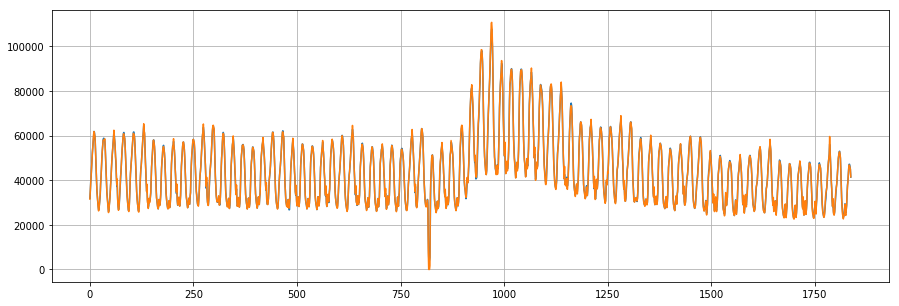

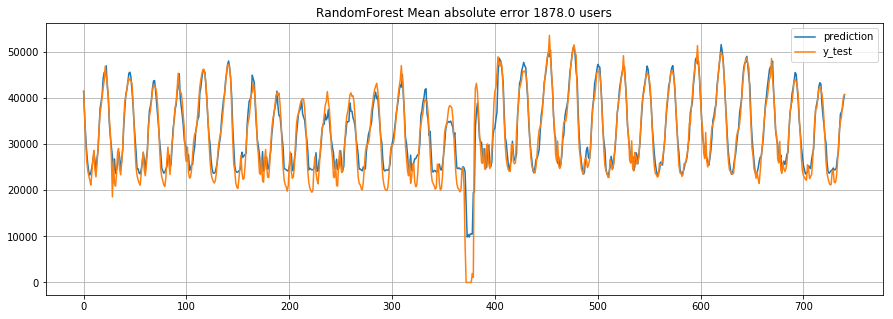

In [41]:
RandomForest_forecast(dataset.Users, test_size=0.3, lag_start=1, lag_end=48)

# Facebook Prophet

Документация по fbprophet: https://facebook.github.io/prophet/docs/quick_start.html

In [42]:
from fbprophet import Prophet

In [43]:
dataset = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])
d = dataset.reset_index()

In [44]:
d.rename(columns = {'Time':'ds', 'Users':'y'}, inplace = True)
print(d.head())

d_train = d.iloc[:-300]
d_test = d.iloc[-300:]

                   ds      y
0 2017-01-01 00:00:00  34002
1 2017-01-01 01:00:00  37947
2 2017-01-01 02:00:00  41517
3 2017-01-01 03:00:00  44476
4 2017-01-01 04:00:00  46234


In [45]:
d.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [46]:
d_train.tail()

,ds,y
2320,2017-04-07 17:00:00,25097
2321,2017-04-07 18:00:00,24623
2322,2017-04-07 19:00:00,24037
2323,2017-04-07 20:00:00,23770
2324,2017-04-07 21:00:00,25153


In [47]:
d_test.head()

,ds,y
2325,2017-04-07 22:00:00,27792
2326,2017-04-07 23:00:00,31039
2327,2017-04-08 00:00:00,33021
2328,2017-04-08 01:00:00,33688
2329,2017-04-08 02:00:00,34714


In [48]:
d_test.tail()

,ds,y
2620,2017-04-20 05:00:00,34833
2621,2017-04-20 06:00:00,35932
2622,2017-04-20 07:00:00,38418
2623,2017-04-20 08:00:00,40238
2624,2017-04-20 09:00:00,40763


In [49]:
m = Prophet() #daily_seasonality, weekly_seasonality
m.fit(d_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [50]:
future = m.make_future_dataframe(freq='H', periods=300) #freq='H' означает, что измерения проводятся каждый час
future.tail()

,ds
2620,2017-04-20 05:00:00
2621,2017-04-20 06:00:00
2622,2017-04-20 07:00:00
2623,2017-04-20 08:00:00
2624,2017-04-20 09:00:00


In [51]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2620,2017-04-20 05:00:00,33346.467777,21275.090029,44602.200330
2621,2017-04-20 06:00:00,36281.937323,24754.716739,47283.867367
2622,2017-04-20 07:00:00,38270.026903,25589.737176,50027.801926
2623,2017-04-20 08:00:00,39948.545263,28608.527495,51000.714938
2624,2017-04-20 09:00:00,41272.606198,29700.453102,53429.708270


In [52]:
prediction = forecast['yhat'][-300:]
actual = d_test['y']
mean_absolute_error(prediction, actual)

6939.490932225799

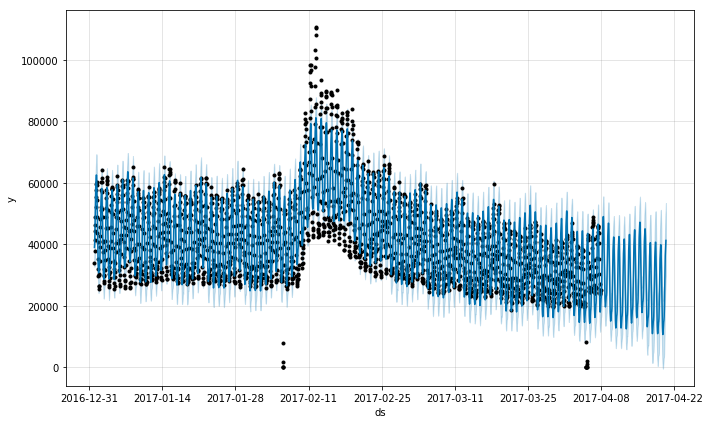

In [53]:
fig1 = m.plot(forecast)

Populating the interactive namespace from numpy and matplotlib


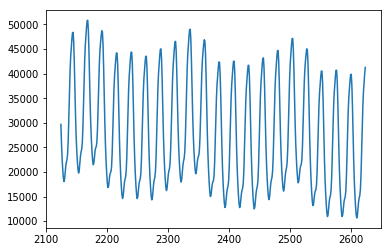

In [54]:
%pylab inline
plot(forecast['yhat'][-500:])

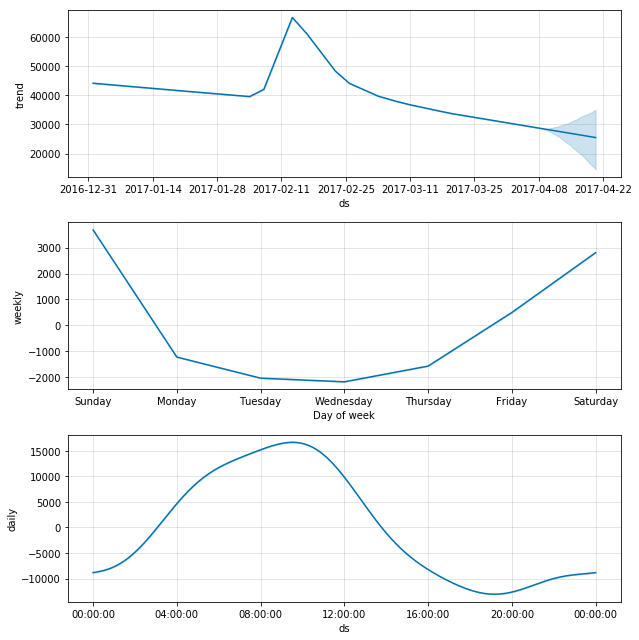

In [55]:
fig2 = m.plot_components(forecast)

In [56]:
metric_df = forecast.set_index('ds')[['yhat']].join(d.set_index('ds').y).reset_index()
metric_df.tail()

,ds,yhat,y
2620,2017-04-20 05:00:00,33346.467777,34833
2621,2017-04-20 06:00:00,36281.937323,35932
2622,2017-04-20 07:00:00,38270.026903,38418
2623,2017-04-20 08:00:00,39948.545263,40238
2624,2017-04-20 09:00:00,41272.606198,40763


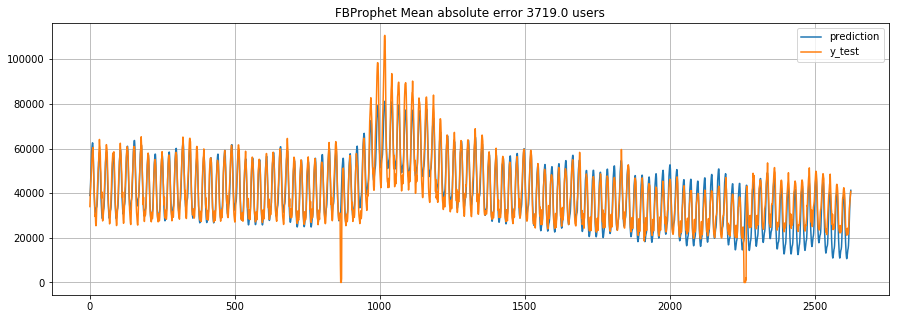

In [57]:
plt.figure(figsize=(15, 5))
plt.plot(metric_df.yhat, label="prediction")
plt.plot(list(metric_df.y), label="y_test")
plt.legend(loc="best")
plt.axis('tight')
plt.title("FBProphet Mean absolute error {} users".format(round(mean_absolute_error(metric_df.yhat, metric_df.y))))
plt.grid(True)
plt.legend()

## Данные по временным рядам https://datamarket.com/data/list/?q=provider%3Atsdl

# Домашнее задание

Скачайте с сайта datamarket.com наиболее понравившийся вам датасет и далее работайте с ним.

Разбейте данные на train и test (test - последние 15%-30% данных в зависимости от размера датасета).

1) Постройте адаптивные модели двойного экспоненциального сглаживания и тройного экспоненциального сглаживания. 
Сделайте предсказания и измерьте ошибки mse и mae на train и test.

2*) Исследуйте данные на стационарность. Проверьте наличие сезонных эффектов, зависимостей от предыдущих значений ряда, сбалансируйте дисперсию с помощью преобразования Бокса-Кокса. Приведите ряд к стационарному и примените к полученному стационарному ряду модель ARMA. Подберите оптимальные параметры p и q для ARMA с помощью минимизации AIC.

3) Постройте предсказание с помощью модели ARIMA (или SARIMA, если вы подозреваете наличие сезонных эффектов в данных). Измерьте ошибки предсказаний на train и test.

4) Сделайте предсказание с помощью fbprophet и измерьте mse и mae предсказания на train и на test

5) Поработайте над созданием новых признаков (лаги, аггрегированные признаки и т.д.) и примените для предсказания линейную регрессию и какой-нибудь нелинейный алгоритм.

6) Сравните результаты всех полученных алгоритмов. Какой алгоритм дал наилучшее качество? Какой алгоритм имеет самое маленькое время настройки параметров при хорошем качестве?

7*) Попробуйте скомбинировать наилучшие модели. Улучшилось ли качество предсказания?

Задания 2 и 7 опциональные.